In [1]:
import feature_engineering.preprocessing
import tensorflow as tf
import LSTM.model
from keras.layers import LSTM,Dense,Flatten
from keras import optimizers
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import datetime
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

In [25]:
pkobp_data = feature_engineering.preprocessing.get_data_by_ticker('PKO.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 11, 30), ['Close'])
pekao_data = feature_engineering.preprocessing.get_data_by_ticker('PEO.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
santander_data = feature_engineering.preprocessing.get_data_by_ticker('SPL.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
ing_data = feature_engineering.preprocessing.get_data_by_ticker('ING.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
mbank_data = feature_engineering.preprocessing.get_data_by_ticker('MBK.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])

In [4]:
pkobp_data = pkobp_data.rename(columns={"Close": "pkobp"})
pekao_data = pekao_data.rename(columns={"Close": "pekao"})
santander_data = santander_data.rename(columns={"Close": "santander"})
ing_data = ing_data.rename(columns={"Close": "ing"})
mbank_data = mbank_data.rename(columns={"Close": "mbank"})

In [5]:
df = pd.concat([pkobp_data, pekao_data, santander_data, ing_data, mbank_data], axis=1)
returns = df.pct_change()

C:\Users\user\AppData\Local\Temp\ipykernel_20372\3983798788.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = df.pct_change()


In [6]:
corr_matrix = returns.corr()
print(corr_matrix)

              pkobp     pekao  santander       ing     mbank
pkobp      1.000000  0.520994   0.471761  0.275788  0.409515
pekao      0.520994  1.000000   0.582107  0.366354  0.511353
santander  0.471761  0.582107   1.000000  0.386272  0.608756
ing        0.275788  0.366354   0.386272  1.000000  0.373640
mbank      0.409515  0.511353   0.608756  0.373640  1.000000


In [7]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,pkobp,pekao,santander,ing,mbank
pkobp,1.000000,0.520994,0.471761,0.275788,0.409515
pekao,0.520994,1.000000,0.582107,0.366354,0.511353
santander,0.471761,0.582107,1.000000,0.386272,0.608756
ing,0.275788,0.366354,0.386272,1.000000,0.373640
mbank,0.409515,0.511353,0.608756,0.373640,1.000000


<Axes: >

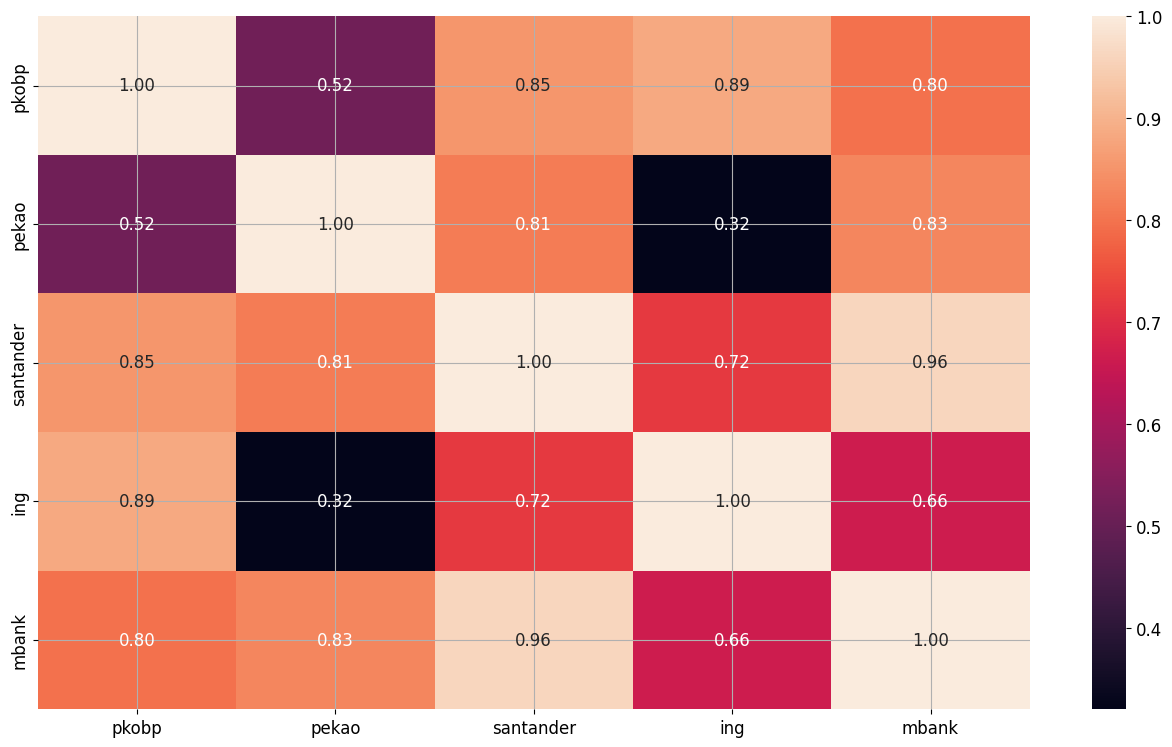

In [8]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

# PKOBP

In [178]:
lookback = 50
num_features = 1
horizon = 1
num_neurons_L1 = 256 * 2
num_neurons_L2 = 256 * 2
num_neurons_dense1 = 1

model = Sequential()

model.add(LSTM(units = num_neurons_L1, input_shape=(lookback,num_features), return_sequences=True, activation = 'relu', dropout=0.3))
model.add(LSTM(num_neurons_L2, activation = 'relu', dropout=0.3, return_sequences=False))
model.add(Flatten())
model.add(Dense(horizon, activation = 'sigmoid'))

model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ['mean_absolute_error'])

In [45]:
pko_scaler = MinMaxScaler(feature_range = (0, 1))

In [62]:
train_pko_scaled = pko_scaler.fit_transform(pkobp_data)

# LOGARYTM

In [17]:
np.log(pkobp_data)

,pkobp
Date,
2016-01-04 00:00:00+01:00,3.122301
2016-01-05 00:00:00+01:00,3.109016
2016-01-07 00:00:00+01:00,3.090504
2016-01-08 00:00:00+01:00,3.065276
2016-01-11 00:00:00+01:00,3.018280
...,...
2023-11-23 00:00:00+01:00,3.844600
2023-11-24 00:00:00+01:00,3.839882
2023-11-27 00:00:00+01:00,3.828424


# ZWROTY LOGARYTMICZNE

In [169]:
pkobp_data = feature_engineering.preprocessing.get_data_by_ticker('PKO.WA', datetime.datetime(2016, 6, 1), datetime.datetime(2020, 12, 31), ['Close'])
pekao_data = feature_engineering.preprocessing.get_data_by_ticker('PEO.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
santander_data = feature_engineering.preprocessing.get_data_by_ticker('SPL.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
ing_data = feature_engineering.preprocessing.get_data_by_ticker('ING.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])
mbank_data = feature_engineering.preprocessing.get_data_by_ticker('MBK.WA', datetime.datetime(2016, 1, 1), datetime.datetime(2020, 12, 31), ['Close'])

In [170]:
pct_returns = pkobp_data.pct_change().dropna()
log_returns = np.log(1+pct_returns)
pko_scaler = MinMaxScaler(feature_range = (0, 1))
train_pko_scaled = pko_scaler.fit_transform(log_returns)

In [171]:
len(train_pko_scaled)

1186

In [172]:
train_pko_scaled

array([[0.58317933],
       [0.57444606],
       [0.57968454],
       ...,
       [0.72058181],
       [0.59973565],
       [0.4225238 ]])

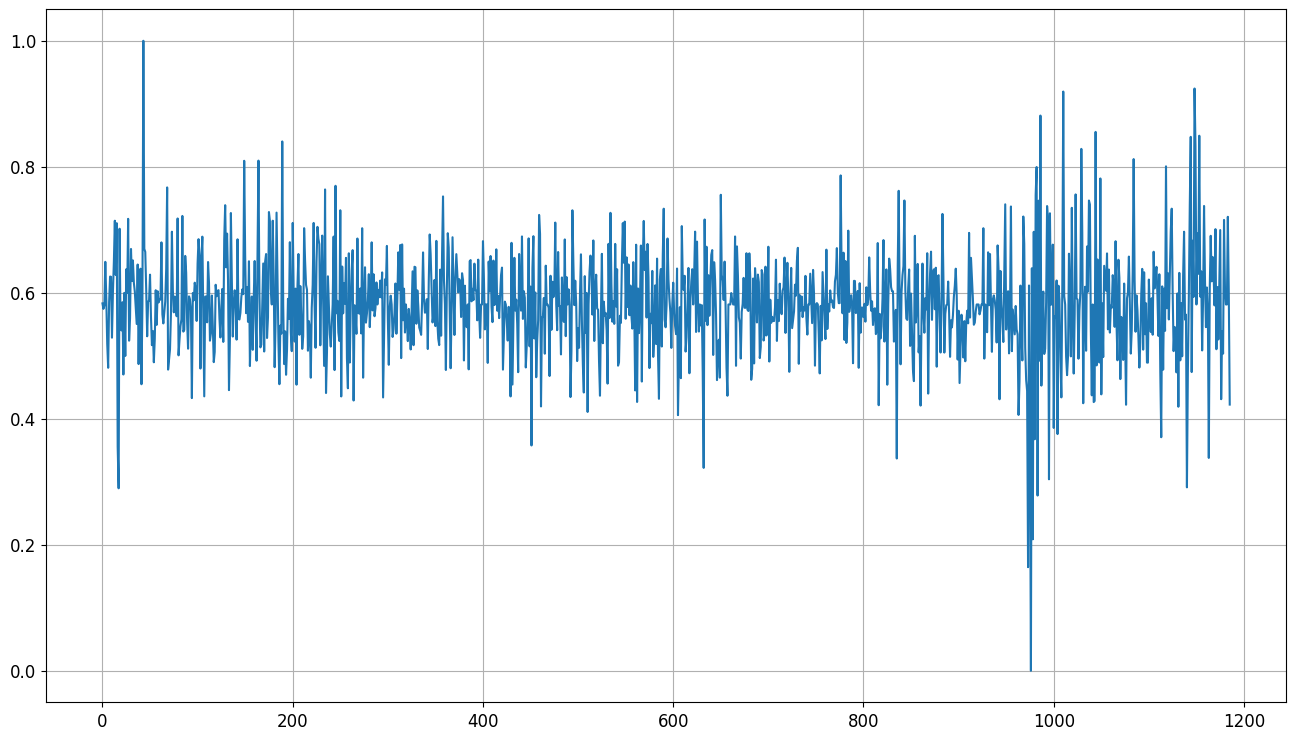

In [173]:
plt.plot(train_pko_scaled)

In [174]:
train_pko_scaled.shape[0]

1186

In [175]:
from statsmodels.tsa.stattools import adfuller
signif=0.05
x = adfuller(train_pko_scaled, autolag='AIC')
output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
output

{'Test Statistic': -11.620588895605755,
 'P-value': 2.3898491805196143e-21,
 'Number of lags': 9,
 'Number of observations': 1176,
 'Reject (signif. level 0.05)': True}

In [176]:
lookback = 50
tmp = []
for i in range(0, train_pko_scaled.shape[0]-lookback):
    a = slice(i, i+lookback)
    tmp.append(train_pko_scaled[a, :])

In [177]:
np.array(tmp).shape

(1136, 50, 1)

In [178]:
data_windows_x = np.array(tmp)
data_windows_y = data_windows_x[:, -1, :]

## Dropout = 0.3

In [181]:
lookback = 50
num_features = 1
horizon = 1
num_neurons_L1 = 256
num_neurons_L2 = 256
num_neurons_dense1 = 1

model = Sequential()

model.add(LSTM(units = num_neurons_L1, input_shape=(lookback,num_features), return_sequences=True, activation = 'relu', dropout=0.3))
model.add(LSTM(num_neurons_L2, activation = 'relu', dropout=0.3, return_sequences=False))
model.add(Flatten())
model.add(Dense(horizon, activation = 'sigmoid'))

model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ['mean_absolute_error'])

In [182]:
model.summary()
fit_model = model.fit(data_windows_x, data_windows_y, epochs=100, batch_size=64, verbose=2)
train_predict = model.predict(data_windows_x)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 50, 128)           66560     
                                                                 
 lstm_26 (LSTM)              (None, 128)               131584    
                                                                 
 flatten_12 (Flatten)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 198273 (774.50 KB)
Trainable params: 198273 (774.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 - 5s - loss: 0.0039 - mean_absolute_error: 0.0665 - 5s/epoch - 262ms/step
Epoch 2/100
18/18 - 2s - loss: 0.0033 - mean_absolute

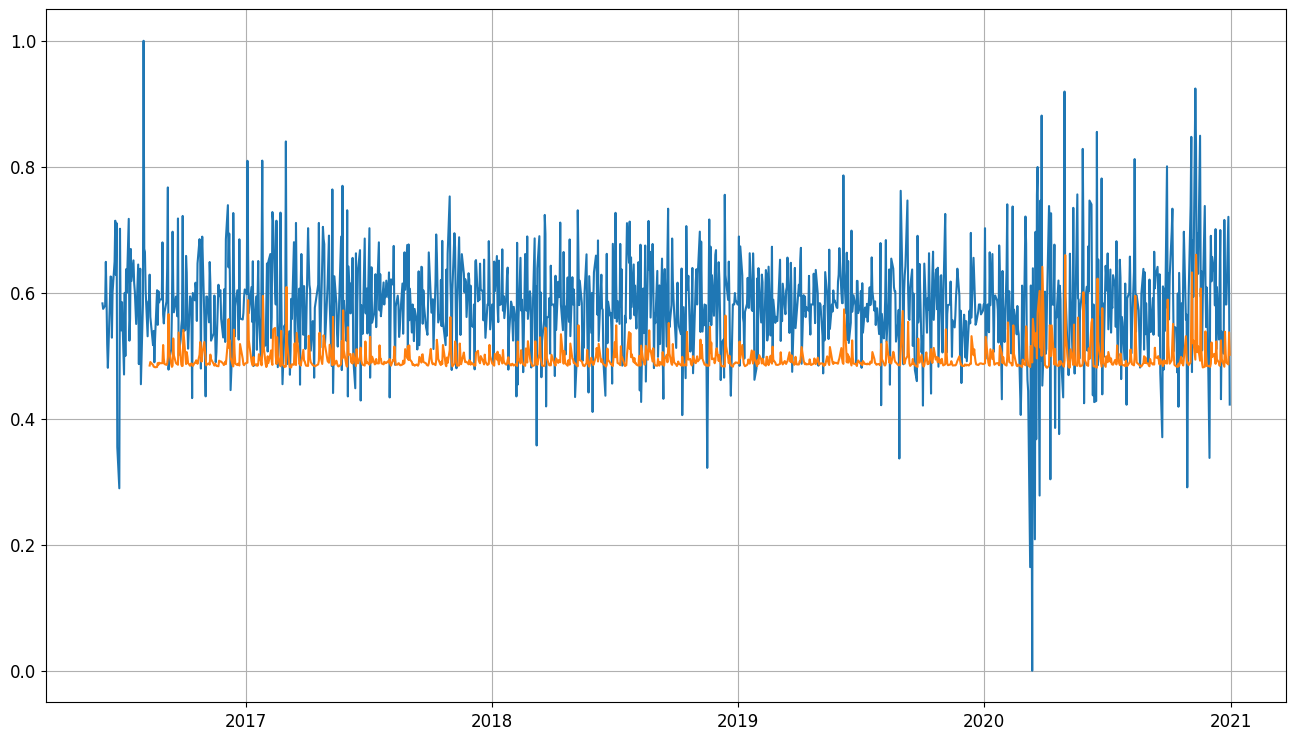

In [183]:
trainPredictPlot = np.empty_like(train_pko_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookback:(len(train_pko_scaled)), :] = train_predict
plt.plot(pkobp_data[1:].index, train_pko_scaled)
plt.plot(pkobp_data[1:].index, trainPredictPlot)

### Dropout = 0.0

In [188]:
lookback = 50
num_features = 1
horizon = 1
num_neurons_L1 = 256
num_neurons_L2 = 256
num_neurons_dense1 = 1

model = Sequential()

model.add(LSTM(units = num_neurons_L1, input_shape=(lookback,num_features), return_sequences=True, activation = 'relu', dropout=0.0))
model.add(LSTM(num_neurons_L2, activation = 'relu', dropout=0.0, return_sequences=False))
model.add(Flatten())
model.add(Dense(horizon, activation = 'sigmoid'))

model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ['mean_absolute_error'])
model.summary()
fit_model = model.fit(data_windows_x, data_windows_y, epochs=100, batch_size=64, verbose=2)
train_predict = model.predict(data_windows_x)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 50, 256)           264192    
                                                                 
 lstm_28 (LSTM)              (None, 256)               525312    
                                                                 
 flatten_13 (Flatten)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 789761 (3.01 MB)
Trainable params: 789761 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 - 8s - loss: 0.0038 - mean_absolute_error: 0.0646 - 8s/epoch - 451ms/step
Epoch 2/100
18/18 - 6s - loss: 0.0032 - mean_absolute_err

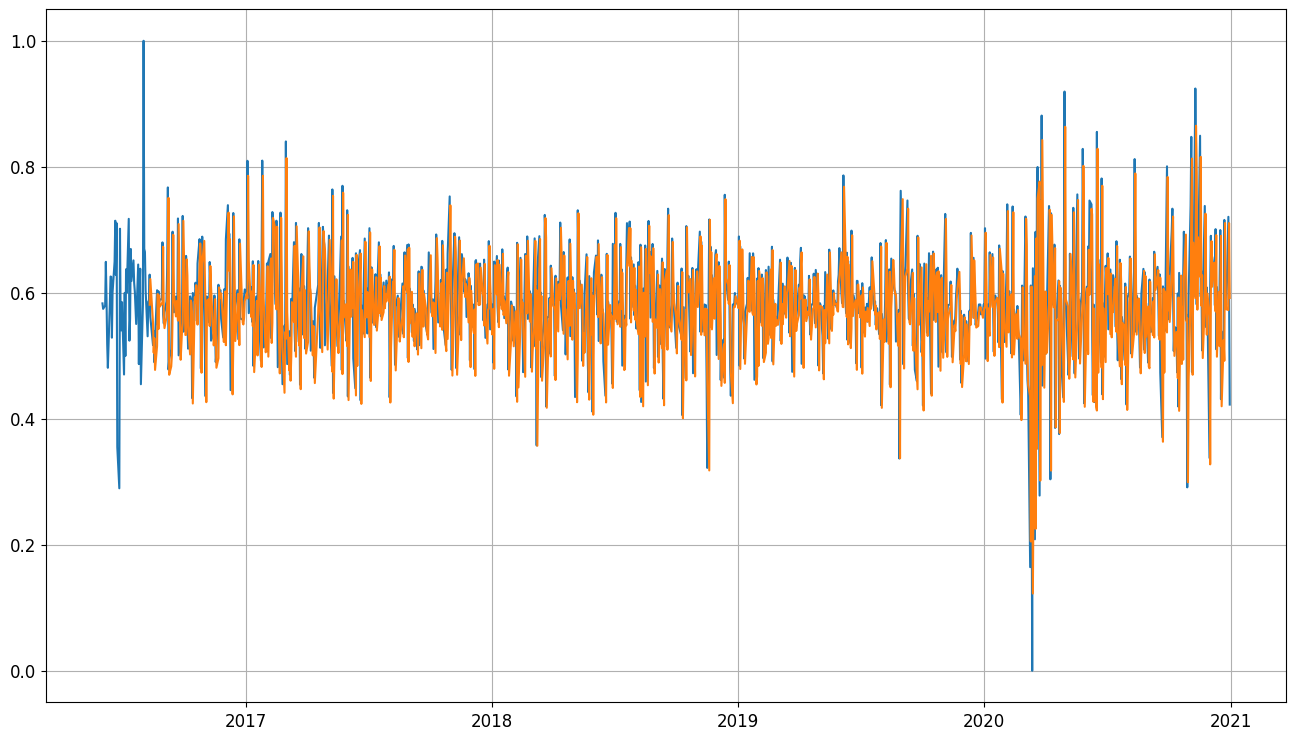

In [261]:
trainPredictPlot = np.empty_like(train_pko_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookback:(len(train_pko_scaled)), :] = train_predict
plt.plot(pkobp_data[1:].index, train_pko_scaled)
plt.plot(pkobp_data[1:].index, trainPredictPlot)

In [195]:
train_predict

array([[0.5809826 ],
       [0.6217397 ],
       [0.5521195 ],
       ...,
       [0.5725735 ],
       [0.7106703 ],
       [0.59177357]], dtype=float32)

In [207]:
# invert_data
invert_scaler = pko_scaler.inverse_transform(train_predict)
invert_diff_data = np.exp(invert_scaler) - 1
print(invert_diff_data[0])
print(pkobp_data.iloc[50].values * (1 + invert_diff_data[0]))
print(pkobp_data.iloc[51].values)

[-0.00010753]
[23.35508769]
[23.62292862]


In [256]:
d = {'invert_scaler': invert_scaler[:, 0],
     'invert_scaler2': invert_scaler2[:, 0],
     'invert_diff_data': invert_diff_data[:, 0],
     'invert_diff_data2': invert_diff_data2[:, 0],
     'invert_data': np.array(invert_data)[:, 0],
     'invert_data2': np.array(invert_data2)[:, 0]}


In [258]:
df = pd.DataFrame(data = d)

In [263]:
len(df.index)

1136

In [275]:
_index = 10
df.iloc[_index*50: (_index+1)*50, -2:] 

,invert_data,invert_data2
500,16.577757,36.316311
501,16.465620,36.120341
502,16.739805,36.770594
503,16.702238,36.734966
504,16.935661,37.296141
505,16.839792,37.144712
506,16.933956,37.411942
507,16.833898,37.260513
508,16.644992,36.922023
509,16.885930,37.518834


In [208]:
invert_diff_data[-20:]

array([[ 0.02427197],
       [ 0.00675988],
       [ 0.01595938],
       [ 0.00989258],
       [-0.00259829],
       [ 0.02663195],
       [-0.01959777],
       [ 0.00478232],
       [-0.01568508],
       [ 0.0059967 ],
       [ 0.02633834],
       [-0.03782851],
       [-0.01335573],
       [-0.0211007 ],
       [ 0.03133535],
       [ 0.0043807 ],
       [-0.00182343],
       [-0.00211203],
       [ 0.03132057],
       [ 0.00247049]], dtype=float32)

In [209]:
invert_data = []
invert_data.append(pkobp_data.iloc[50].values * (1+invert_diff_data[0]))
for i in range(1,len(invert_diff_data)):
    invert_data.append(invert_data[i-1] * (1 + invert_diff_data[i]))

In [278]:
# ODWRÓCENIE TRANSFORMACJI DANYCH
invert_scaler2 = pko_scaler.inverse_transform(data_windows_y)
invert_diff_data2 = np.exp(invert_scaler2) - 1
invert_data2 = []
invert_data2.append(pkobp_data.iloc[50].values * (1+invert_diff_data2[0]))
for i in range(1,len(invert_diff_data2)):
    invert_data2.append(pkobp_data.iloc[i+50].values * (1 + invert_diff_data2[i]))

In [279]:
invert_data2

[array([23.39188834]),
 array([23.89127197]),
 array([23.40091093]),
 array([22.79819791]),
 array([22.69230145]),
 array([21.93899134]),
 array([21.84642024]),
 array([22.3739569]),
 array([21.91243624]),
 array([22.30539501]),
 array([22.22782121]),
 array([22.29635663]),
 array([22.33915357]),
 array([23.37022339]),
 array([22.65607501]),
 array([22.41726624]),
 array([22.44198774]),
 array([22.56163474]),
 array([23.15639454]),
 array([24.96228763]),
 array([22.72985301]),
 array([22.34893206]),
 array([22.05456818]),
 array([22.27942596]),
 array([23.62326837]),
 array([23.23848732]),
 array([22.97263979]),
 array([23.17806185]),
 array([23.10938454]),
 array([22.90441959]),
 array([24.55540957]),
 array([22.86983128]),
 array([22.70261768]),
 array([22.63162038]),
 array([22.5623316]),
 array([24.26403298]),
 array([22.98597084]),
 array([22.7810655]),
 array([23.86310347]),
 array([24.00094585]),
 array([23.41141417]),
 array([22.78543502]),
 array([23.31283298]),
 array([23.330

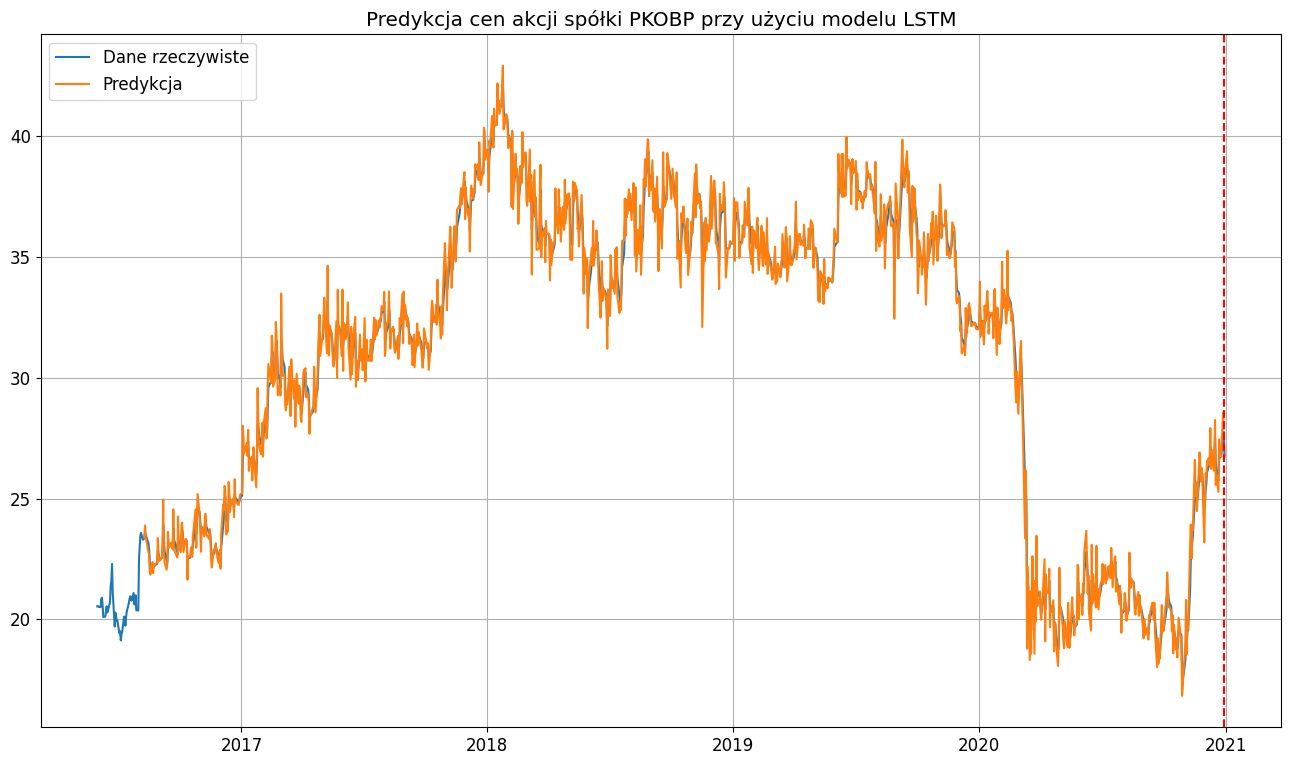

In [281]:
trainPredictPlot = np.empty_like(pkobp_data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[50:(len(train_pko_scaled)), :] = invert_data2
# testPredictPlot = np.empty_like(test_pkobp_data)
# testPredictPlot[:,:] = np.nan
# testPredictPlot[50:(len(transformed_test_data)), :] = invert_test
# testPlot = np.empty_like()
# testPlot[:,:] = np.nan
# test_pkobp_data.iloc[:50, :] = np.nan
plt.plot(pkobp_data, label='Dane rzeczywiste')
plt.plot(pkobp_data.index, trainPredictPlot, label='Predykcja')
# plt.plot(test_pkobp_data, label='Dane rzeczywiste testowe')
# plt.plot(test_pkobp_data.index, testPredictPlot, label='Predykcja na zbiorze testowym')
plt.axvline(x=pkobp_data.index[-1], c='r', linestyle='--')
plt.title("Predykcja cen akcji spółki PKOBP przy użyciu modelu LSTM")
plt.legend()
plt.show()

In [4]:
import numpy as np
np.zeros(np.array([1,2]))

array([[0., 0.]])

In [57]:
test_pkobp_data = feature_engineering.preprocessing.get_data_by_ticker('PKO.WA', datetime.datetime(2021, 1, 1), datetime.datetime(2023, 9, 30), ['Close'])
log_test_change = test_pkobp_data.pct_change().dropna()
# log_test_change = log_test_change.rename(columns={"Close": "pkobp"})
print(log_test_change)
transformed_test_data = pko_scaler.transform(np.log(1+log_test_change))
tmp2 = []
for i in range(0, transformed_test_data.shape[0]-lookback):
    a = slice(i, i+lookback)
    tmp2.append(transformed_test_data[a, :])

test_data_windows_x = np.array(tmp2)
test_predict = model.predict(test_data_windows_x)

                              Close
Date                               
2021-01-04 00:00:00+01:00  0.013231
2021-01-05 00:00:00+01:00  0.016495
2021-01-06 00:00:00+01:00  0.000000
2021-01-07 00:00:00+01:00  0.074375
2021-01-08 00:00:00+01:00  0.027376
...                             ...
2023-09-25 00:00:00+02:00 -0.020237
2023-09-26 00:00:00+02:00  0.025966
2023-09-27 00:00:00+02:00 -0.021858
2023-09-28 00:00:00+02:00 -0.001470
2023-09-29 00:00:00+02:00  0.022379

[696 rows x 1 columns]
21/21 [==============================] - 4s 194ms/step


### koniec testu na zwrotach logarytmicznych

In [63]:
tmp = []
for i in range(0, train_pko_scaled.shape[0]-lookback):
    a = slice(i, i+lookback)
    tmp.append(train_pko_scaled[a, :])

data_windows_x = np.array(tmp)

In [14]:
data_windows_y = data_windows_x[:, -1, :]
data_windows_y.shape

(1979, 1)

In [15]:
data_windows_y[0]

array([0.18784346])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 256)           264192    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 789761 (3.01 MB)
Trainable params: 789761 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
fit_model = model.fit(data_windows_x, data_windows_y, epochs=100, batch_size=64, verbose=2)

Epoch 1/100


KeyboardInterrupt: 

In [364]:
train_predict = model.predict(data_windows_x)

39/39 [==============================] - 6s 139ms/step


## test

In [44]:
def _adjust_X_train_data(X_train_data, lookback):
    tmp = []
    for i in range(0, X_train_data.shape[0]-lookback):
        a = slice(i, i+lookback)
        tmp.append(X_train_data[a, :])
    
    return np.array(tmp)


def prepare_data_for_model(train_data, lookback):
    X_train = _adjust_X_train_data(train_data, lookback)
    Y_train = X_train[:, -1, :]

    return X_train, Y_train

In [58]:
scaled_train_data = pko_scaler.transform(pkobp_data.loc[:'2020'])
X_train, Y_train = prepare_data_for_model(scaled_train_data, lookback)
lookback = 50
X_train.shape

(1240, 50, 1)

In [60]:
trainPredictPlot = np.empty_like(X_train[1]+lookback)
trainPredictPlot[:,:] = np.nan
# trainPredictPlot[lookback:(len(X_train+lookback)), :].shape
# trainPredictPlot[lookback:(len(X_train+lookback)), :] = Y_train_predictions

In [61]:
trainPredictPlot.shape

(50, 1)

## koniec testu

In [365]:
test_pkobp_data = feature_engineering.preprocessing.get_data_by_ticker('PKO.WA', datetime.datetime(2021, 1, 1), datetime.datetime(2021, 5, 31), ['Close'])

In [366]:
transformed_test_data = pko_scaler.transform(test_pkobp_data)

In [367]:
transformed_test_data.shape

(106, 1)

In [368]:
tmp2 = []
for i in range(0, transformed_test_data.shape[0]-lookback):
    a = slice(i, i+lookback)
    tmp2.append(transformed_test_data[a, :])

test_data_windows_x = np.array(tmp2)

In [369]:
test_predict = model.predict(test_data_windows_x)

2/2 [==============================] - 0s 65ms/step


In [370]:
invert_data = pko_scaler.inverse_transform(train_predict)

In [371]:
invert_test = pko_scaler.inverse_transform(test_predict)

In [372]:
trainPredictPlot = np.empty_like(pkobp_data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[50:(len(train_pko_scaled)), :] = invert_data

In [373]:
testPredictPlot = np.empty_like(test_pkobp_data)
testPredictPlot[:,:] = np.nan
testPredictPlot[50:(len(transformed_test_data)), :] = invert_test

In [ ]:
testPlot = np.empty_like()
testPlot[:,:] = np.nan

In [389]:
test_pkobp_data.iloc[:50, :] = np.nan

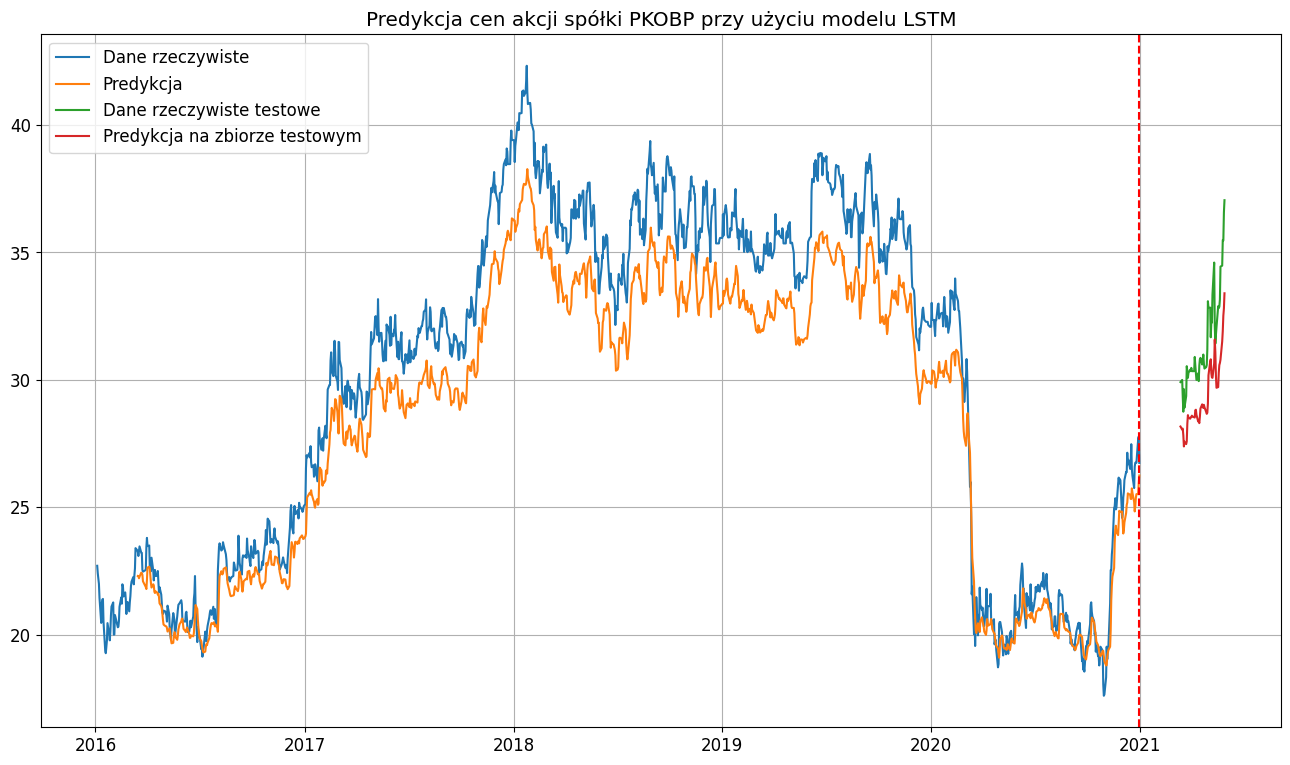

In [391]:
plt.plot(pkobp_data, label='Dane rzeczywiste')
plt.plot(pkobp_data.index, trainPredictPlot, label='Predykcja')
plt.plot(test_pkobp_data, label='Dane rzeczywiste testowe')
plt.plot(test_pkobp_data.index, testPredictPlot, label='Predykcja na zbiorze testowym')
plt.axvline(x=pkobp_data.index[-1], c='r', linestyle='--')
plt.title("Predykcja cen akcji spółki PKOBP przy użyciu modelu LSTM")
plt.legend()
plt.show()

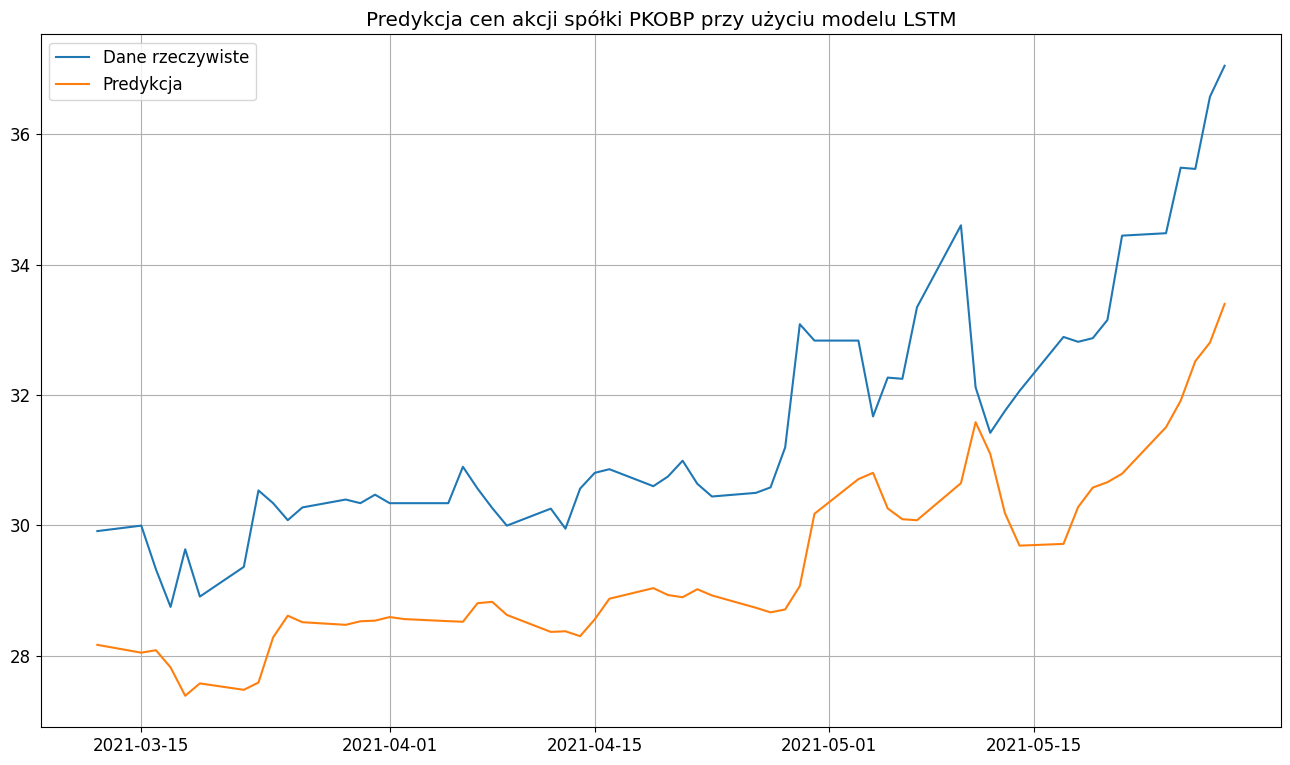

In [393]:
plt.plot(test_pkobp_data, label='Dane rzeczywiste')
plt.plot(test_pkobp_data.index, testPredictPlot, label='Predykcja')
plt.title("Predykcja cen akcji spółki PKOBP przy użyciu modelu LSTM")
plt.legend()
plt.show()

In [432]:
pkobp = feature_engineering.preprocessing.get_data_by_ticker('PKO.WA', datetime.datetime(2023, 6, 20), datetime.datetime(2023, 8, 30), ['Close'])
pekao = feature_engineering.preprocessing.get_data_by_ticker('PEO.WA', datetime.datetime(2023, 6, 20), datetime.datetime(2020, 12, 31), ['Close'])
santander = feature_engineering.preprocessing.get_data_by_ticker('SPL.WA', datetime.datetime(2023, 6, 20), datetime.datetime(2020, 12, 31), ['Close'])
ing = feature_engineering.preprocessing.get_data_by_ticker('ING.WA', datetime.datetime(2023, 6, 20), datetime.datetime(2020, 12, 31), ['Close'])
mbank = feature_engineering.preprocessing.get_data_by_ticker('MBK.WA', datetime.datetime(2023, 6, 20), datetime.datetime(2020, 12, 31), ['Close'])

In [ ]:
pkobp_data = pkobp_data.rename(columns={"Close": "pkobp"})
pekao_data = pekao_data.rename(columns={"Close": "pekao"})
santander_data = santander_data.rename(columns={"Close": "santander"})
ing_data = ing_data.rename(columns={"Close": "ing"})
mbank_data = mbank_data.rename(columns={"Close": "mbank"})

In [433]:
pkobp.shape

(50, 1)

In [ ]:
df = pd.concat([pkobp_data, pekao_data, santander_data, ing_data, mbank_data], axis=1)

corr_matrix = df.corr()
print(corr_matrix)

              pkobp     pekao  santander       ing     mbank
pkobp      1.000000  0.515559   0.853299  0.885499  0.795783
pekao      0.515559  1.000000   0.813758  0.320495  0.828979
santander  0.853299  0.813758   1.000000  0.719340  0.960975
ing        0.885499  0.320495   0.719340  1.000000  0.664042
mbank      0.795783  0.828979   0.960975  0.664042  1.000000


# PEKAO

# SANTANDER

# ING

In [ ]:
# MBANK